In [1]:
import pandas as pd
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

c:\Users\E_Hom\anaconda3\envs\dkernel\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
gpu = tf.config.experimental.list_physical_devices('GPU')
gpu

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpu[0], True)

In [65]:
data_path = r'D:\projects\z datasets\cifar-10'
labels_path = os.path.join(data_path, 'trainLabels.csv')
train_dir = os.path.join(data_path, 'train')
reduced_dataset_dir = os.path.join(data_path, 'reduced_train')
test_dir = r'D:\projects\z datasets\cifar-10\test'

In [47]:
# Load labels.csv
labels_df = pd.read_csv(labels_path)  # Ensure this path matches the actual CSV location
labels_df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [49]:
# Encode labels
label_encoder = LabelEncoder()
labels_df['encoded_label'] = label_encoder.fit_transform(labels_df['label'])


#### Train Data

In [41]:
# Sample 2000 images per class
reduced_df = labels_df.groupby('label').apply(lambda x: x.sample(n=4000, random_state=42)).reset_index(drop=True)

# Create a new directory for the reduced dataset
reduced_dataset_dir = reduced_dataset_dir
os.makedirs(reduced_dataset_dir, exist_ok=True)

# Iterate through the reduced DataFrame and copy the images
original_train_dir = train_dir  # Path to your original train folder with all images


In [71]:



for _, row in reduced_df.iterrows():
    img_id = row['id']
    img_label = row['label']
    src_path = os.path.join(original_train_dir, f"{img_id}.png")  # Adjust extension as per your dataset
    dst_dir = os.path.join(reduced_dataset_dir, img_label)
    os.makedirs(dst_dir, exist_ok=True)
    dst_path = os.path.join(dst_dir, f"{img_id}.png")
    shutil.copy(src_path, dst_path)

print("Reduced dataset created successfully!")


Reduced dataset created successfully!


#### Test Data

In [ ]:
# Step 1: Create a new directory for unused images
for_test_dir = os.path.join(data_path, "for_test_dir")
os.makedirs(for_test_dir, exist_ok=True)

# Step 2: Find unused images
# Get all IDs from the original dataset
all_ids = set(labels_df['id'])

# Get IDs used in the reduced dataset
used_ids = set(reduced_df['id'])

# Calculate unused IDs
unused_ids = all_ids - used_ids

print(f"Found {len(unused_ids)} unused images.")


In [42]:

# Step 3: Create folder structure and copy unused images
for img_id in unused_ids:
    # Get the label of the current image
    img_label = labels_df.loc[labels_df['id'] == img_id, 'label'].values[0]
    
    # Define source and destination paths
    src_path = os.path.join(original_train_dir, f"{img_id}.png")  # Adjust the extension if needed
    dst_dir = os.path.join(for_test_dir, img_label)
    
    # Ensure the label folder exists
    os.makedirs(dst_dir, exist_ok=True)
    
    # Copy the image to the new directory
    dst_path = os.path.join(dst_dir, f"{img_id}.png")
    shutil.copy(src_path, dst_path)

print("Unused images moved to the for_test_dir successfully!")


Found 10000 unused images.
Unused images moved to the for_test_dir successfully!


In [20]:
data = tf.keras.utils.image_dataset_from_directory(reduced_dataset_dir, image_size= (32, 32), batch_size= 32)

Found 40000 files belonging to 10 classes.


In [53]:
test_data = tf.keras.utils.image_dataset_from_directory(for_test_dir, image_size= (32, 32), batch_size= 32)

Found 10000 files belonging to 10 classes.


In [21]:
data = data.map(lambda x, y: (x / 255.0, y))

In [54]:
test_data = test_data.map(lambda x, y: (x / 255.0, y))

In [22]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1)

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

## Model
###### Pre-trained Model

In [24]:
from tensorflow.keras.applications.resnet import ResNet50

In [25]:
base_model = ResNet50(weights= 'imagenet', input_shape= (224, 224, 3), include_top= False)


In [26]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

##### Add calssification to pre-trained model

In [27]:
model = Sequential([
    tf.keras.layers.Input(shape= (32, 32, 3)),
    tf.keras.layers.UpSampling2D(size= (7, 7)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(1024, activation= 'relu'),
    Dense(512, activation= 'relu'),
    Dense(10, activation= 'softmax', name= 'classificaiton')    
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 classificaiton (Dense)      (None, 10)                5

In [28]:
model.compile(optimizer= tf.keras.optimizers.SGD(), loss= 'sparse_categorical_crossentropy', metrics= ['accuracy']) # change: optimizer= 'adam'

In [32]:
checkpoint = ModelCheckpoint('best_model.h5', save_best_only= True, monitor= "val_loss")
early_stop = EarlyStopping(patience=3, restore_best_weights= True)

In [33]:
history1_1 = model.fit(train, validation_data= val, batch_size=32, verbose= True, epochs= 3, callbacks= [checkpoint, early_stop])

Epoch 1/3


875/875 [==============================] - 174s 198ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1986 - val_accuracy: 0.9554
Epoch 2/3
875/875 [==============================] - 169s 193ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.2118 - val_accuracy: 0.9535
Epoch 3/3
875/875 [==============================] - 169s 193ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.2129 - val_accuracy: 0.9504


In [34]:
model.evaluate(test)

125/125 [==============================] - 13s 61ms/step - loss: 0.2636 - accuracy: 0.9438


[0.26355698704719543, 0.9437500238418579]

In [ ]:
inputs = tf.keras.layers.Input(shape= ())
inputs = tf.keras.layers.UpSampling2D(size= (7, 7))

In [36]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history1_1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


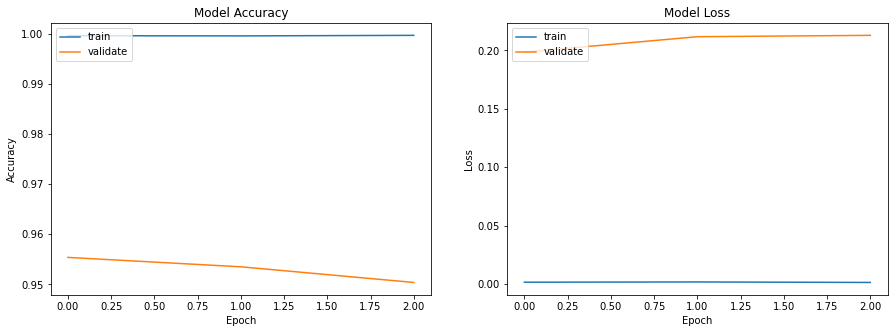

In [37]:
plotmodelhistory(history1_1)

In [45]:
predctions = model.predict(test_data)

313/313 [==============================] - 17s 53ms/step


In [64]:
model.evaluate(test_data)

313/313 [==============================] - 17s 52ms/step - loss: 0.2436 - accuracy: 0.9466


[0.24358205497264862, 0.9466000199317932]

In [ ]:
submission_file = "submission.csv"

# Official labels for CIFAR-10
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Load test dataset
test_data = tf.keras.utils.image_dataset_from_directory( test_dir, image_size=(32, 32),  # Change this to your model's input size
    batch_size=32, shuffle=False )  # Ensure order matches file IDs

test_data = test_data.map(lambda x, y: x / 255.0)

# Get image file paths and IDs
file_paths = test_data.file_paths
image_ids = [int(os.path.splitext(os.path.basename(fp))[0]) for fp in file_paths]

# Make predictions
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Map predicted class indices to label names
predicted_labels = [label_names[class_idx] for class_idx in predicted_classes]

# Create the submission DataFrame
submission_df = pd.DataFrame({
    "id": image_ids,
    "label": predicted_labels
})

# Sort by ID to match required format
submission_df = submission_df.sort_values(by="id")

# Save to CSV
submission_df.to_csv(submission_file, index=False)

print(f"Submission file saved to {submission_file}")

Found 0 files belonging to 0 classes.


ValueError: No images found in directory D:\projects\z datasets\cifar-10\test. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [70]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Model input image size
image_size = (32, 32)  # Change this to your model's expected input size

# Function to load and preprocess images
def load_test_images(test_dir, image_size):
    test_images = []
    image_ids = []
    
    for file in os.listdir(test_dir):
        if file.endswith(('.png')):  # Check valid image formats
            image_path = os.path.join(test_dir, file)
            image = load_img(image_path, target_size=image_size)  # Load image
            image_array = img_to_array(image) / 255.0  # Normalize
            test_images.append(image_array)
            image_ids.append(os.path.splitext(file)[0])  # Extract file ID without extension
    
    return np.array(test_images), image_ids

# Load test images and IDs
test_images, image_ids = load_test_images(test_dir, image_size)

# Load your trained model
model = tf.keras.models.load_model("your_model.h5")  # Replace with your model path

# Predict the test images
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Class labels (must match Kaggle competition labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
mapped_labels = [class_labels[label] for label in predicted_labels]

# Create submission DataFrame
submission_df = pd.DataFrame({
    "id": image_ids,
    "label": mapped_labels
})

# Sort by ID (optional, depends on competition requirements)
submission_df = submission_df.sort_values(by="id").reset_index(drop=True)

# Save to CSV
submission_file = "submission.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Submission file saved as {submission_file}")